## Caravan customer identification study

- Author: Tommy Lam
- Date: 22 Apr, 2019
- Programming language: R
- Data Source: The CoIL Challenge 2000 http://liacs.leidenuniv.nl/~puttenpwhvander/library/cc2000/
- Abstract: This study targets the caravcan customer identification. The study begins with data exploration and followed by model analysis to predict the potential customers.

# Table of Contents
##   1  -  [Data Wrangling](#wrangling)

##   2  -  [Data Exploration and Visualisation](#viz)
> - [Summary](#summary1)

##   3  -  [Data Modelling](#modelling)

> 3.1 - [Logistic regression classification](#logistic)

> 3.2 - [Random forest](#forest)

>  3.3 - [KNN classification](#knn)

> - [Summary](#summary2)


### Libraries required:

In [443]:
library(tidyverse)
library(plyr)
library(dplyr)
library("Hmisc")

# Modelling
library(caret)
library(VGAM)
library(LogicReg)
library(ranger)

library(reshape2)
library(ggplot2)
library(corrplot)
library(tidyverse)
library(datasets)

options(warn=-1)

## Data Importing

First of all, the training data would be imported in order to build a model based on training data.

1. TICDATA2000.txt: Dataset to train and validate prediction models and build a description (5822 customer records). Each record consists of 86 attributes, containing sociodemographic data (attribute 1-43) and product ownership (attributes 44-86).The sociodemographic data is derived from zip codes. All customers living in areas with the same zip code have the same sociodemographic attributes. Attribute 86, "CARAVAN:Number of mobile home policies", is the target variable.
2. TICEVAL2000.txt: Dataset for predictions (4000 customer records). It has the same format as TICDATA2000.txt, only the target is missing. Participants are supposed to return the list of predicted targets only. All datasets are in tab delimited format. The meaning of the attributes and attribute values is given below.
3. TICTGTS2000.txt Targets for the evaluation set.

Data dictionary: https://kdd.ics.uci.edu/databases/tic/dictionary.txt

In [453]:
train_data = read.csv('data/ticdata2000.txt',sep = '',header = F)
predict_data = read.csv('data/TICEVAL2000.txt',sep = '',header = F)
target_data = read.csv('data/TICTGTS2000.txt',sep = '',header = F)

head(train_data,3)
head(predict_data,3)
head(target_data,3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,33,1,3,2,8,0,5,1,3,7,⋯,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,1,4,1,4,6,⋯,0,0,0,1,0,0,0,0,0,0
3,37,1,2,2,8,0,4,2,4,3,⋯,0,0,0,1,0,0,0,0,0,0


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,33,1,4,2,8,0,6,0,3,5,⋯,0,0,0,0,1,0,0,0,0,0
2,6,1,3,2,2,0,5,0,4,5,⋯,2,0,0,0,1,0,0,0,0,0
3,39,1,3,3,9,1,4,2,3,5,⋯,1,0,0,0,1,0,0,0,0,0


,V1
,<int>
1,0
2,1
3,0


<a id='wrangling'></a>
## Data Wrangling


Some of the data are represented by coding, for example, the age-group is presented as 1 to 6. Since these variables are continuous and would be useful to build the models, they are converted into mean values for each group.

In [454]:
# age
age = data.frame('V4' = c(1,2,3,4,5,6), 'age' = c(25,35,45,55,65,75))
# MGODRK Roman catholic 
L3 = data.frame('V6' = c(0,1,2,3,4,5,6,7,8,9), 'L3' = c(0,5.5,17,30,43,56,69,82,94,100))
# Income
L4 = data.frame('V42' = c(0,1,2,3,4,5,6,7,8,9), 'L4' = c(0,25,74.5,149.5,349.5,749.5,2999.5,7499.5,14999.5,20000))


A function is built for converting the coding data, and update the training data accordingly.

In [455]:
update_value = function(data,data_name,column, update) {
    temp = data[column] %>% join(update)
    data[column] = temp[names(update)[2]]
    assign(data_name,data,envir=.GlobalEnv)
}

In [456]:
# update the training data
update_value(train_data,'train_data','V4',age)
update_value(train_data,'train_data','V6',L3)
update_value(train_data,'train_data','V42',L4)

# update the target data
update_value(predict_data,'predict_data','V4',age)
update_value(predict_data,'predict_data','V6',L3)
update_value(predict_data,'predict_data','V42',L4)


Joining by: V4

Joining by: V6

Joining by: V42

Joining by: V4

Joining by: V6

Joining by: V42



In [457]:
head(train_data,3)
head(predict_data,3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86
,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,33,1,3,35,8,0.0,5,1,3,7,⋯,0,0,0,1,0,0,0,0,0,0
2,37,1,2,35,8,5.5,4,1,4,6,⋯,0,0,0,1,0,0,0,0,0,0
3,37,1,2,35,8,0.0,4,2,4,3,⋯,0,0,0,1,0,0,0,0,0,0


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85
,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,33,1,4,35,8,0.0,6,0,3,5,⋯,0,0,0,0,1,0,0,0,0,0
2,6,1,3,35,2,0.0,5,0,4,5,⋯,2,0,0,0,1,0,0,0,0,0
3,39,1,3,45,9,5.5,4,2,3,5,⋯,1,0,0,0,1,0,0,0,0,0


So now the data can ready for further analysis.

<a id='viz'></a>
## Data Exploration and Visualisation

In [8]:
# colnames(target_data) = 'V86'
# explore = cbind(predict_data,target_data)
explore = train_data
head(explore,3)
explore$V86 = as.character(explore$V86)
# explore$V5 = as.character(explore$V5)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86
,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,33,1,3,35,8,0.0,5,1,3,7,⋯,0,0,0,1,0,0,0,0,0,0
2,37,1,2,35,8,5.5,4,1,4,6,⋯,0,0,0,1,0,0,0,0,0,0
3,37,1,2,35,8,0.0,4,2,4,3,⋯,0,0,0,1,0,0,0,0,0,0


### Age distribution
- 40-50 is the largest group, and followed by 30-40 and 50-60

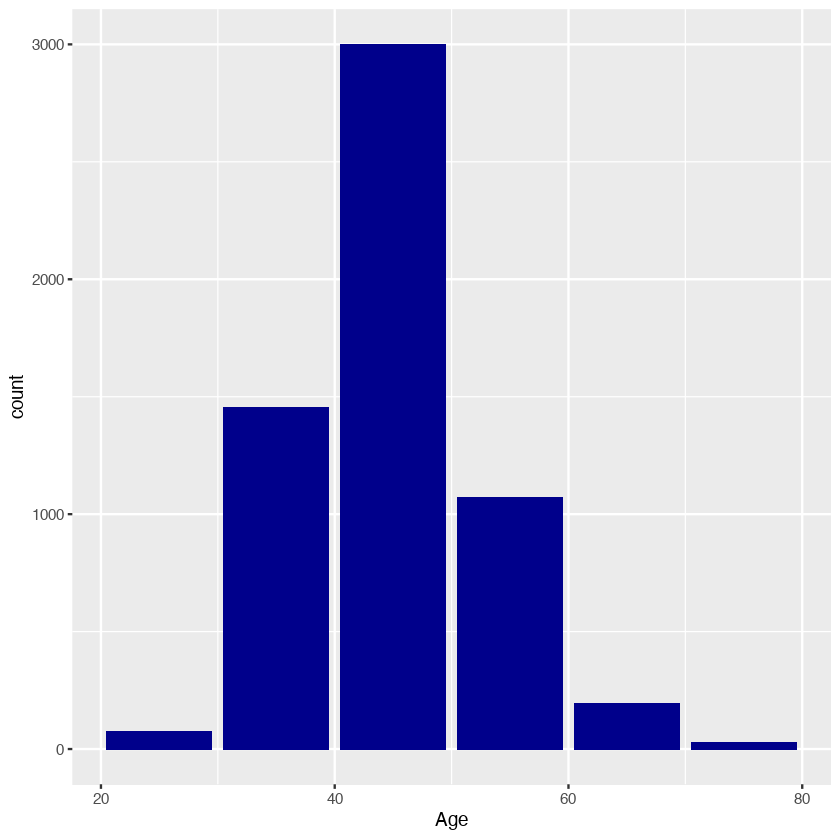

In [9]:
g=ggplot(data = explore)
g + 
geom_bar(aes(x = V4),position = 'dodge', fill= 'dark blue') + 
xlab('Age')

### Age split among caravan users and non-users
The following graph shows the age distribution split by caravan customers. 

0: non-caravan customers, 1: caravan customers

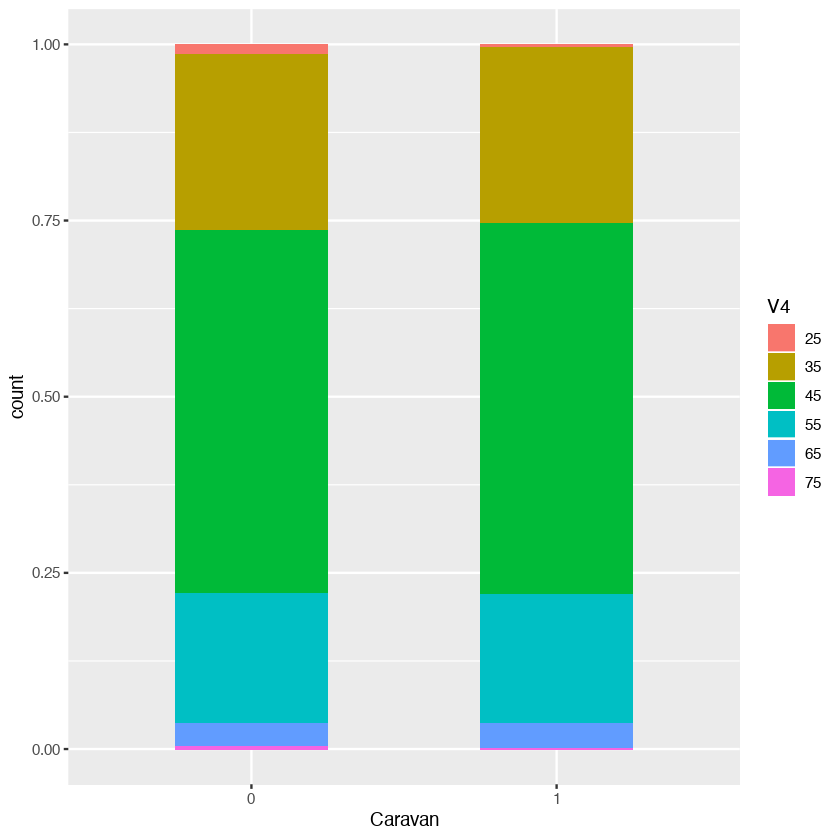

In [10]:
explore$V4 = as.character(explore$V4)
ggplot(data =  explore) + 
geom_bar(aes(x = V86,fill = V4),position = 'fill',width = 0.5) + 
xlab('Caravan') 

From the graph, we can see that caravan customers are generally younger the non-caravan customers, while the upper 3 stacked bar representing age from 20 to 50.

In [11]:
means <- aggregate(V3 ~  V86, explore, mean)
means

V86,V3
<chr>,<dbl>
0,2.671721
1,2.790230


### Average Income

The graph below shows the distribution of average income between caravan users or non-users. Caravan users generally have higher income than non-user.

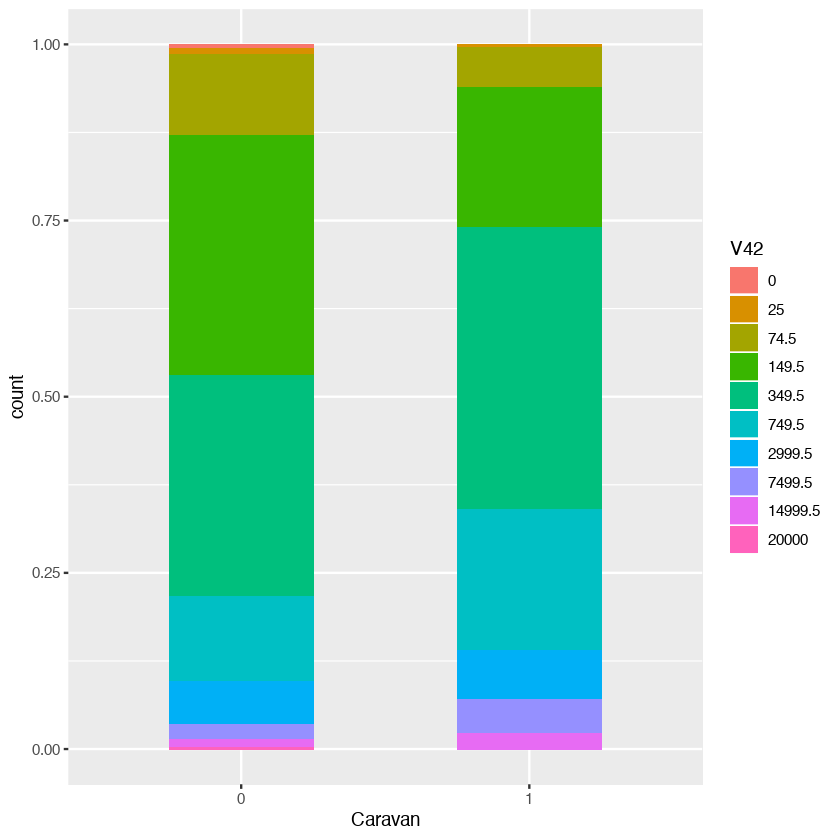

In [13]:
explore$V42 = as.character(explore$V42)
explore$V42 <- factor(explore$V42, levels = c('0','25','74.5','149.5','349.5','749.5','2999.5','7499.5','14999.5','20000'))
ggplot(data = explore ) + geom_bar(aes(x = V86,fill = V42),position = 'fill',width = 0.5) + xlab('Caravan') 

### Average Household Size

In [14]:
paste('Carvan customer:',round(mean(as.numeric(explore[explore$V83 == 1,]$V3)),2))
paste('Non-Carvan customer:',round(mean(as.numeric(explore[explore$V83 == 0,]$V3)),2))

[1] "Carvan customer: 2.82"

[1] "Non-Carvan customer: 2.67"

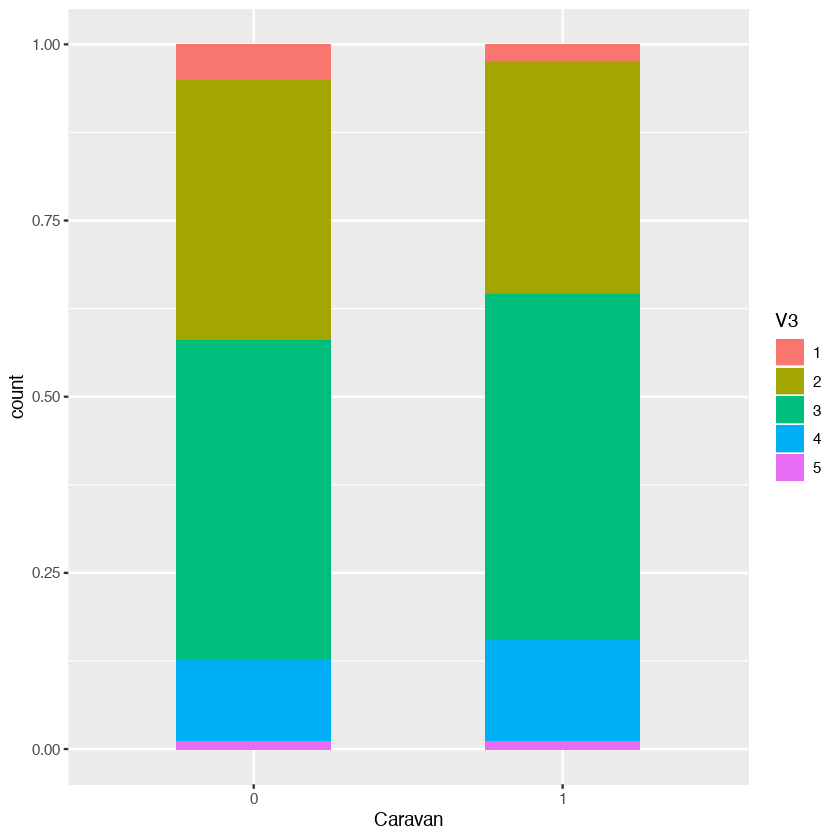

In [15]:
explore$V3 = as.character(explore$V3)
ggplot(data = explore ) + geom_bar(aes(x = V86,fill = V3),position = 'fill',width = 0.5) + xlab('Caravan') 

This graph shows the caravan customers tend to have a larger household size.

Now, we will focus on the caravan user. 

In [15]:
# only caravan customer are recorded
caravan = explore[explore$V86==1,]

### Customer main type
 
The following graph shows the constitution of each customer type:

In [17]:
caravan$V5 = as.character(caravan$V5)
ggplot(data=caravan)+
geom_bar(aes(forcats::fct_infreq(V5)), fill ='dark blue') + 
xlab('Customer main type')

ERROR: Error in eval(expr, envir, enclos): 找不到物件 'caravan'


The major customer type is 'Family with grown ups'. Second and third are 'Driven Growers' and 'Average Family' respectively.

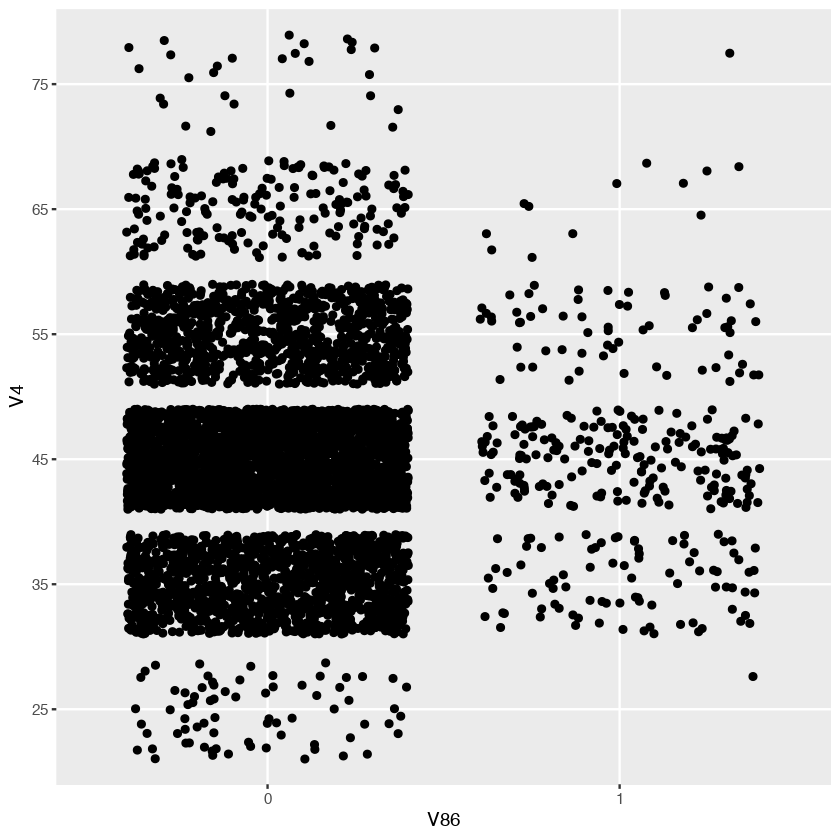

In [18]:
ggplot(data = explore) +
geom_jitter(aes(x = V86 , y = V4))

From the jitter plot above, we may also find that most caravan using are fall within age range of 30 - 50.

### Correlation
In this section, we will explore the correlation of caravan against the rest of the variables, so as to discover some important factors that drive customers to use caravan insurance.

In [19]:
## Generating the correlation matrix
res2 = rcorr(as.matrix(explore))
corr = as.data.frame(res2$r[86,])
colnames(corr) = 'corr'
corr$abs = abs(corr$corr)

The table following shows the top correlated variables against caravan insurance user

In [20]:
corr[order(corr$abs,decreasing = T),][2:10,]

,corr,abs
,<dbl>,<dbl>
V47,0.15090971,0.15090971
V68,0.14421046,0.14421046
V82,0.10569950,0.10569950
V44,0.09646269,0.09646269
V43,0.09593826,0.09593826
V59,0.09444599,0.09444599
V61,0.09136116,0.09136116
V18,-0.09056133,0.09056133
V65,0.08938747,0.08938747


V47 (Contribution car policies), V43 (Purchasing power class), V44 (Contribution private third party insurance) and V68 (Number of car policies) are the top correlated variables.

We can understand customers related to car policies show strong relation to caravan usage. Also, those with higher contribution to private thrid party insurance are also more related to caravan usage.

<a id='summary1'></a>
## Summary
The customers of caravan tend to be younger, higher income and with higher size of household. They would be the target group to be foucused in the future marketing plannig.

Also, according to the correlation analysis, we should pay more attention to customers with stronger contribution to car policies, since they have higher chances to have a caravan insurance.

<a id='modelling'></a>
# Data Modelling

<a id='logistic'></a>
## 1. Logistic regression classification

By checking on the unique values in V86, there are either 0 or 1.
Therefore, logistic regression is suggested:

In [458]:
unique(train_data[,86])

[1] 0 1

In [460]:
# Logistic regression by training the target variable (V86) with all other variables
model_log = glm(formula = V86~.,data = train_data) 
summary(model_log)


Call:
glm(formula = V86 ~ ., data = train_data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.67195  -0.08688  -0.04634  -0.00606   1.04632  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.714e-01  4.303e-01   1.793 0.073068 .  
V1           3.573e-03  2.251e-03   1.587 0.112476    
V2          -7.216e-03  7.673e-03  -0.940 0.347059    
V3          -1.305e-03  7.175e-03  -0.182 0.855671    
V4           1.111e-03  4.956e-04   2.242 0.025021 *  
V5          -1.577e-02  1.010e-02  -1.562 0.118459    
V6          -1.027e-03  6.055e-04  -1.696 0.089882 .  
V7          -4.743e-03  6.588e-03  -0.720 0.471633    
V8          -3.314e-03  5.911e-03  -0.561 0.575060    
V9          -7.197e-03  6.323e-03  -1.138 0.255074    
V10          8.618e-03  7.483e-03   1.152 0.249504    
V11          2.005e-03  7.140e-03   0.281 0.778902    
V12          5.671e-03  7.555e-03   0.751 0.452927    
V13         -3.780e-03  6.542e-03  -0.578 

In [461]:
# Applying the model on the testing data.
glm.probs <- predict(model_log, 
                    newdata = predict_data, 
                    type = "response")

#### Result

The result of the logistic regession gives the predictions within the range from -1 to 1. The following graph shows the distribution of the prediction based the logistic regression model applying on the testing data.

In the next step, since we need to predict the potential customers, only 0 or 1 are allowed in the prediction of testing data. Therefore, we need to define a decision boundary to predict the potential customers.

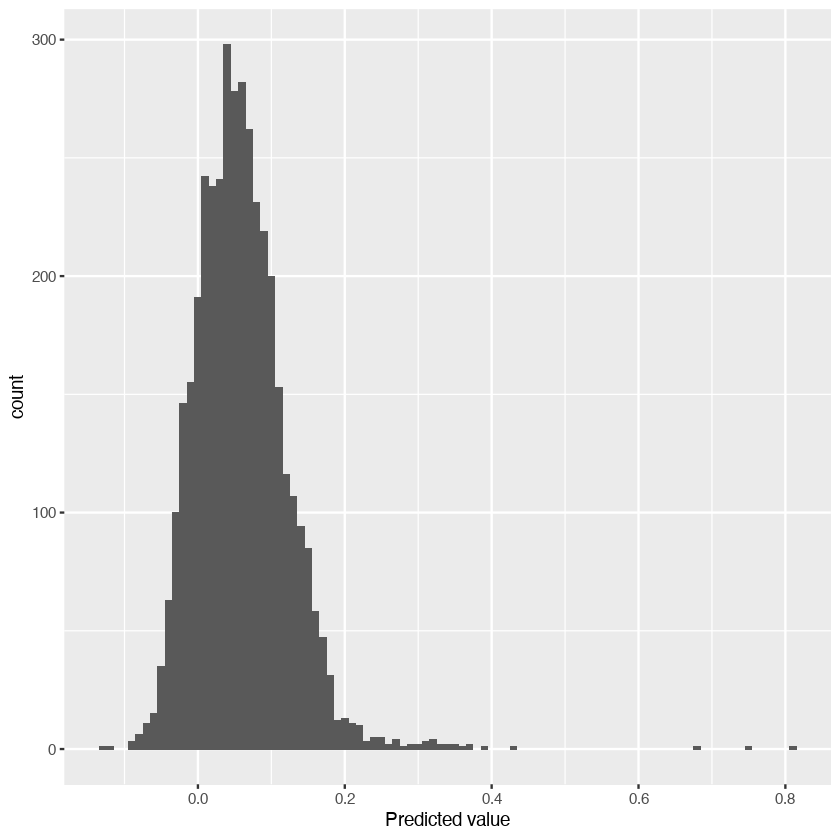

In [498]:
# plot the distribution of the probability
ggplot(data = data.frame(prob = round(glm.probs,2))) + 
geom_bar(aes(x = prob))+
xlab('Predicted value')

In order to identify the decision boundary, prediction result will be calculated for each boundary level.

In [491]:
logistic_result = data.frame(boundary = integer(), accuarcy = integer(), sensitivity = integer(), specificity = integer())

for (bound in seq(0,1,by = 0.05)) {
glm.pred <- ifelse(glm.probs > bound, 1, 0) # decision boundary
predicted_result_log = as.data.frame(glm.pred)

acc = as.data.frame(confusionMatrix(as.factor(predicted_result_log[,1]),as.factor(target_data$V1))[3])[1,]
sens = as.data.frame(confusionMatrix(as.factor(predicted_result_log[,1]),as.factor(target_data$V1))[4])[1,]
spec = as.data.frame(confusionMatrix(as.factor(predicted_result_log[,1]),as.factor(target_data$V1))[4])[2,]

logistic_result[nrow(logistic_result)+1,] = c(bound,acc,sens,spec)
    }

In [492]:
head(logistic_result)

,boundary,accuarcy,sensitivity,specificity
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00,0.20750,0.1592238,0.97058824
2,0.05,0.50600,0.4872408,0.80252101
3,0.10,0.78250,0.7993089,0.51680672
4,0.15,0.89975,0.9431154,0.21428571
5,0.20,0.92975,0.9848485,0.05882353
6,0.25,0.93575,0.9928230,0.03361345


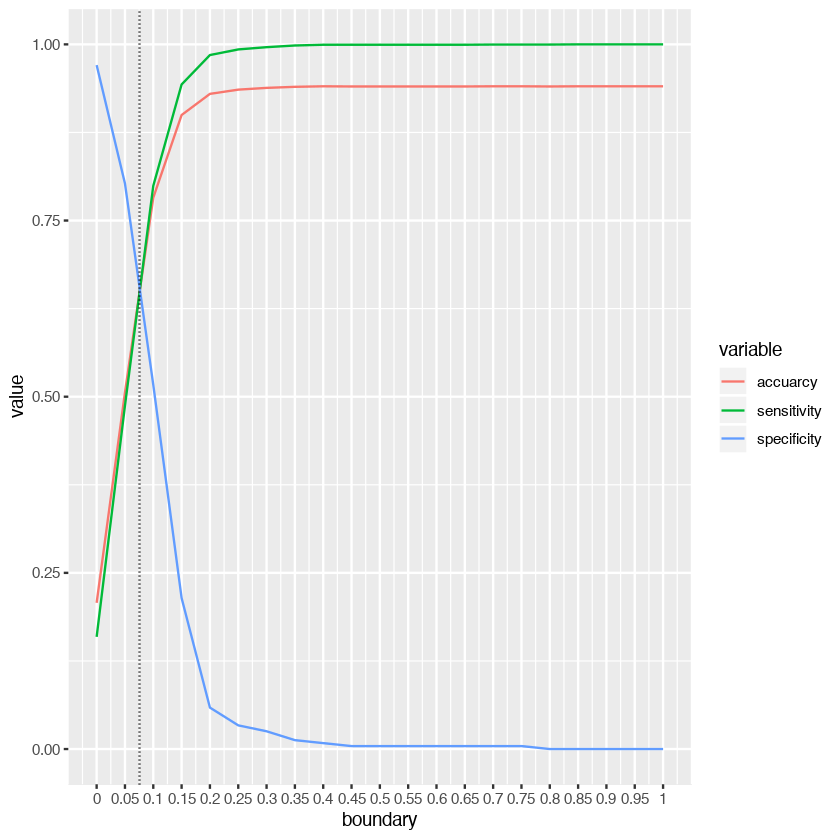

In [493]:
logistic_result.m = melt(logistic_result, id.vars = 'boundary')

ggplot(data = logistic_result.m) + 
geom_line(aes(x = boundary, y = value, color = variable)) +
scale_x_continuous(breaks=seq(0,1,by = 0.05), labels=seq(0,1,by = 0.05),limits=c(0,1)) + 
geom_vline(xintercept = 0.075,linetype = 'dotted')

From the graph, in order to balance both accuracy and specificity, 0.075 would the optimum decision boundary for logistic regression classification. 

Here is the confusion matrix with 0.075 decision boundary:

In [488]:
glm.pred <- ifelse(glm.probs > 0.075, 1, 0)
predicted_result_log = as.data.frame(glm.pred)
confusionMatrix(as.factor(predicted_result_log[,1]),as.factor(target_data$V1))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2486   82
         1 1276  156
                                          
               Accuracy : 0.6605          
                 95% CI : (0.6456, 0.6752)
    No Information Rate : 0.9405          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0944          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.6608          
            Specificity : 0.6555          
         Pos Pred Value : 0.9681          
         Neg Pred Value : 0.1089          
             Prevalence : 0.9405          
         Detection Rate : 0.6215          
   Detection Prevalence : 0.6420          
      Balanced Accuracy : 0.6581          
                                          
       'Positive' Class : 0               
                        

## Stepwise Logistic regression
Stepwise regression is the methodology to select the subset variables for the regression. It is believed that with the selected variables, the model can give a better result.  

In [497]:
# The lengthy selection steps are hidden by 'trace = 0'.
model_log_step = step(model_log,trace = 0)

In [496]:
# summary(model_log_step) # The summary will show all steps involved.
model_log_step # final result


Call:  glm(formula = V86 ~ V1 + V4 + V5 + V6 + V10 + V17 + V18 + V21 + 
    V22 + V28 + V30 + V35 + V36 + V40 + V41 + V43 + V44 + V46 + 
    V47 + V55 + V57 + V58 + V59 + V63 + V76 + V78 + V79 + V80 + 
    V82 + V83 + V84 + V85, data = train_data)

Coefficients:
(Intercept)           V1           V4           V5           V6          V10  
   0.575857     0.003423     0.001043    -0.014818    -0.000637     0.005309  
        V17          V18          V21          V22          V28          V30  
  -0.006917    -0.013017    -0.006461     0.003207     0.003270    -0.002473  
        V35          V36          V40          V41          V43          V44  
  -0.064307    -0.066524     0.004631    -0.012629     0.003776     0.010269  
        V46          V47          V55          V57          V58          V59  
  -0.015846     0.010417    -0.016615     0.196509     0.061684     0.012909  
        V63          V76          V78          V79          V80          V82  
  -0.047607     0.038802 

In [468]:
# Applying the model on the testing data.
glm_step.probs <- predict(model_log_step, 
                    newdata = predict_data, 
                    type = "response")

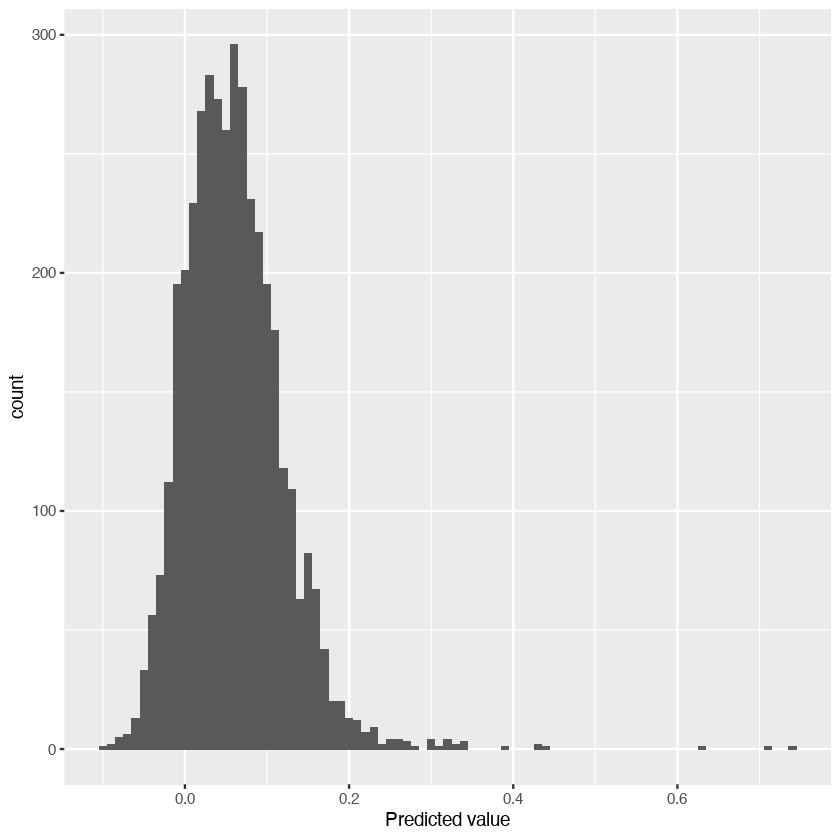

In [499]:
# Distribution of the predicted result
ggplot(data = data.frame(prob = round(glm_step.probs,2))) + 
geom_bar(aes(x = prob)) +
xlab('Predicted value')

Similar table for identifying the decision boundary.

In [448]:
step_logistic_result = data.frame(boundary = integer(), accuarcy = integer(), sensitivity = integer(), specificity = integer())

for (bound in seq(0,1,by = 0.05)) {
glm_step.pred <- ifelse(glm_step.probs > bound, 1, 0) # decision boundary
predicted_result_log_step = as.data.frame(glm_step.pred)

acc = as.data.frame(confusionMatrix(as.factor(predicted_result_log_step[,1]),as.factor(target_data$V1))[3])[1,]
sens = as.data.frame(confusionMatrix(as.factor(predicted_result_log_step[,1]),as.factor(target_data$V1))[4])[1,]
spec = as.data.frame(confusionMatrix(as.factor(predicted_result_log_step[,1]),as.factor(target_data$V1))[4])[2,]

step_logistic_result[nrow(step_logistic_result)+1,] = c(bound,acc,sens,spec)
    }

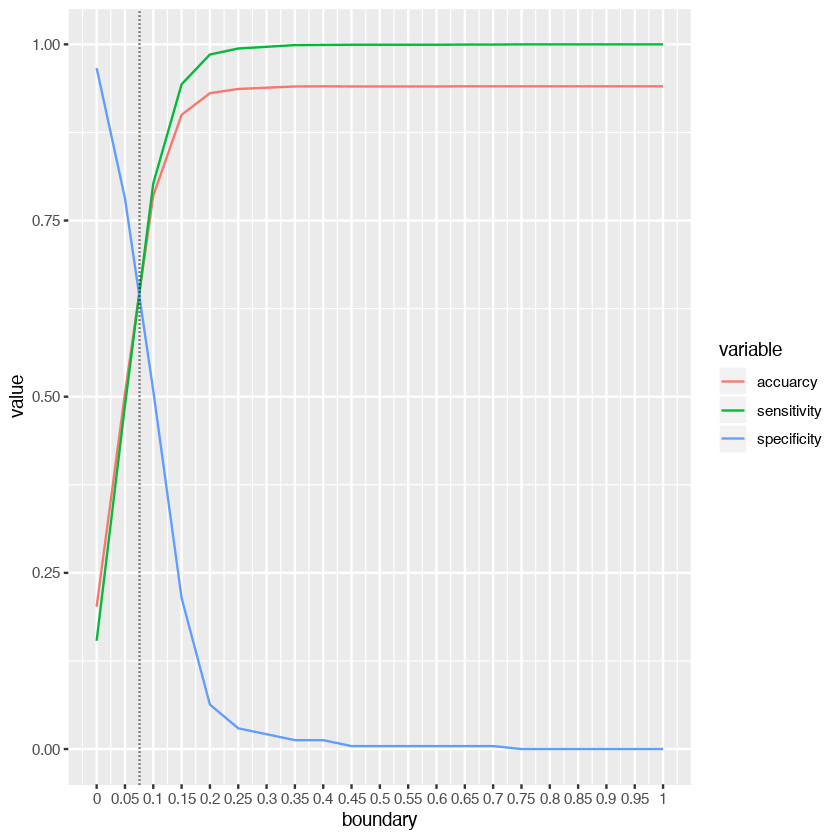

In [439]:
step_logistic_result.m = melt(step_logistic_result, id.vars = 'boundary')

ggplot(data = step_logistic_result.m) + 
geom_line(aes(x = boundary, y = value, color = variable)) +
scale_x_continuous(breaks=seq(0,1,by = 0.05), labels=seq(0,1,by = 0.05),limits=c(0,1)) +
geom_vline(xintercept = 0.075,linetype = 'dotted')

Similar result as the non-stepwise logistic regression, 0.075 is suggested to be the optimal decision boundary to balance both accuarcy and specificity.

In [441]:
glm_step.pred <- ifelse(glm_step.probs > 0.075, 1, 0)
predicted_result_log_step = as.data.frame(glm_step.pred)

confusionMatrix(as.factor(predicted_result_log_step[,1]),as.factor(target_data$V1))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2501   83
         1 1261  155
                                          
               Accuracy : 0.664           
                 95% CI : (0.6491, 0.6786)
    No Information Rate : 0.9405          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0953          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.6648          
            Specificity : 0.6513          
         Pos Pred Value : 0.9679          
         Neg Pred Value : 0.1095          
             Prevalence : 0.9405          
         Detection Rate : 0.6252          
   Detection Prevalence : 0.6460          
      Balanced Accuracy : 0.6580          
                                          
       'Positive' Class : 0               
                        

<a id='forest'></a>
## Random forest

By default, the train function without any arguments re-runs the model over 25 bootstrap samples and across 3 options of the tuning parameter (the tuning parameter for ranger is mtry; the number of randomly selected predictors at each cut in the tree).

In [421]:
# caret modelling
# model_lm = lm(V86~.,data = train_data)
model_rf = train(as.factor(V86)~., data = train_data, method ='ranger')

In [422]:
model_rf
# predict
pred = predict(model_rf, predict_data)

Random Forest 

5822 samples
  85 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 5822, 5822, 5822, 5822, 5822, 5822, ... 
Resampling results across tuning parameters:

  mtry  splitrule   Accuracy   Kappa        
   2    gini        0.9402383  -0.0002248962
   2    extratrees  0.9403518   0.0000000000
  43    gini        0.9237299   0.0537354412
  43    extratrees  0.9271623   0.0529420035
  85    gini        0.9196270   0.0522444856
  85    extratrees  0.9248498   0.0520325605

Tuning parameter 'min.node.size' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were mtry = 2, splitrule = extratrees
 and min.node.size = 1.

In [428]:
confusionMatrix(pred, as.factor(target_data$V1))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 3762  238
         1    0    0
                                          
               Accuracy : 0.9405          
                 95% CI : (0.9327, 0.9476)
    No Information Rate : 0.9405          
    P-Value [Acc > NIR] : 0.5172          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 1.0000          
            Specificity : 0.0000          
         Pos Pred Value : 0.9405          
         Neg Pred Value :    NaN          
             Prevalence : 0.9405          
         Detection Rate : 0.9405          
   Detection Prevalence : 1.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positive' Class : 0               
                        

Accuracy: 94.05%

Specificity: 0%


Random Forest shows a high accuarcy but with a low specificity, which means we cannot locate the potential customers. Hence, this model would not be considered.

<a id='knn'></a>
## KNN Classifier
KNN is one of the most popular machine learning algorithm. The 'K' is referring to the number of nearest neighbors to take vote from, in order to classify the testing data.

In [12]:
# define an auxiliary function that calculates the majority votes
majority <- function(x) {
   uniqx <- unique(x)
   uniqx[which.max(tabulate(match(x, uniqx)))]
}

In [13]:
# KNN function (distance can be one of euclidean, maximum, manhattan, canberra, binary or minkowski)
knn <- function(train.data, train.label, test.data, K=3, distance = 'euclidean'){
    ## count number of train samples
    train.len <- nrow(train.data)
    
    ## count number of test samples
    test.len <- nrow(test.data)
    
    ## calculate distances between samples
    dist <- as.matrix(dist(rbind(test.data, train.data), method= distance))[1:test.len, (test.len+1):(test.len+train.len)]
    
    ## for each test sample...
    for (i in 1:test.len){
        ### find its K nearest neighbours from training samples
        nn <- as.data.frame(sort(dist[i,], index.return = TRUE))[1:K,2]
        
        ### calculate the predicted labels according to the majority vote
        test.label[i]<- (majority(train.label[nn]))
    }
    
    ## return the class labels as output
    return (test.label)
}

In [14]:
# select the data for KNN classifier
train.data = train_data %>% select(1:85)
train.label = train_data$V86
test.data = predict_data %>% select(1:85)
test.label = target_data$V1

Here is an example of using KNN classifier when k = 3:

In [15]:
# K = 3 (3 nearest neighbors)
knn_result_3 = knn(train.data, train.label, test.data, K=3)

Now, in order to select the best k for the KNN model, the classifier will be run from k = 1 to 50.

In [506]:
# run KNN from 1 to 50 nearest neighbors and store the results into a list
knn_result = list()
for (k in 1:50) {
    knn_result[k] = list(knn(train.data, train.label, test.data, K=k))
}

In [518]:
knn_summary = data.frame(k = integer(), accuarcy = integer(), sensitivity = integer(), specificity = integer())

for (k in 1:50) {

acc = as.data.frame(confusionMatrix(as.factor(as.data.frame(knn_result[k])[,1]), as.factor(target_data$V1))[3])[1,]
sens = as.data.frame(confusionMatrix(as.factor(as.data.frame(knn_result[k])[,1]), as.factor(target_data$V1))[4])[1,]
spec = as.data.frame(confusionMatrix(as.factor(as.data.frame(knn_result[k])[,1]), as.factor(target_data$V1))[4])[2,]

knn_summary[nrow(knn_summary)+1,] = c(k,acc,sens,spec)
    }

The graph below shows the model performance under different values of K.

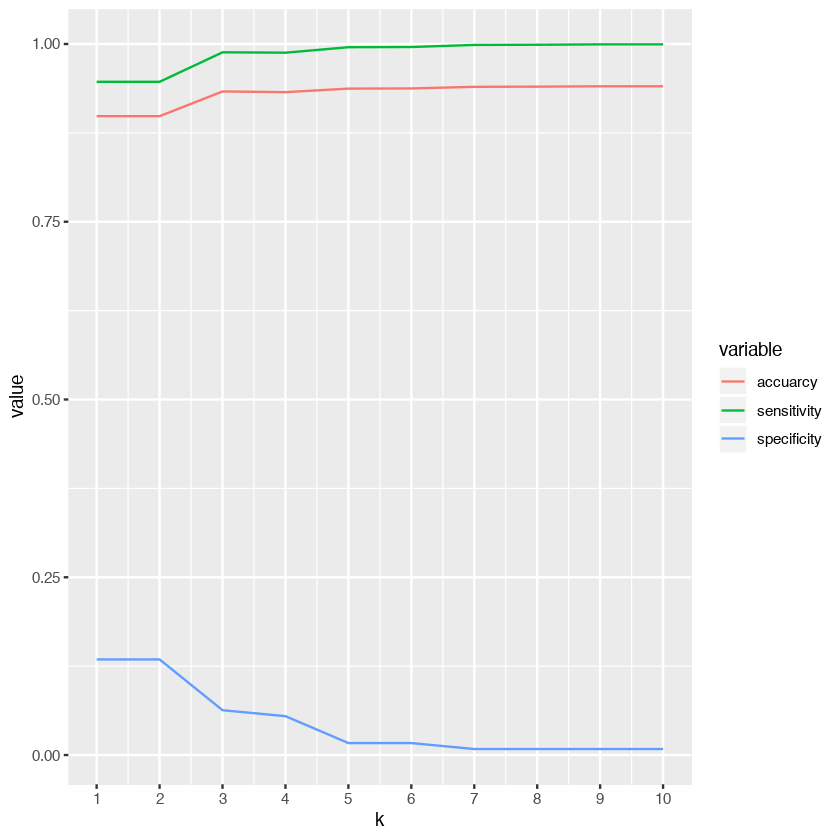

In [523]:
knn_summary.m = melt(knn_summary[1:10,], id.vars = 'k')

ggplot(data = knn_summary.m) + 
geom_line(aes(x = k, y = value, color = variable)) +
scale_x_continuous(breaks=seq(1,10,by = 1), labels=seq(1,10,by = 1),limits=c(1,10)) 

As we can see, after k = 3, the accuarcy stays almost stationary and the specificity drops significantly. This means the model cannot identify the potential customers efficiently after K = 3.

Therefore, K = 3 would be the optimal value in this KNN classifier.

Here is the summary of KNN classification with K = 3:

In [512]:
confusionMatrix(as.factor(as.data.frame(knn_result[3])[,1]), as.factor(target_data$V1))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 3718  223
         1   44   15
                                          
               Accuracy : 0.9332          
                 95% CI : (0.9251, 0.9408)
    No Information Rate : 0.9405          
    P-Value [Acc > NIR] : 0.9741          
                                          
                  Kappa : 0.0792          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.98830         
            Specificity : 0.06303         
         Pos Pred Value : 0.94342         
         Neg Pred Value : 0.25424         
             Prevalence : 0.94050         
         Detection Rate : 0.92950         
   Detection Prevalence : 0.98525         
      Balanced Accuracy : 0.52566         
                                          
       'Positive' Class : 0               
                        

<a id='summary2'></a>
## Summary

In [531]:
model_summary = data.frame(model = character(), accuarcy = double(), Specificity = double(), Negative.Pred = double(),stringsAsFactors = F
                    )


model_summary[nrow(model_summary)+1,] = c('Logistic Regression Classification', 66.05,65.55,10.89)
model_summary[nrow(model_summary)+1,] = c('Stepwise Logistic Regression Classification', 66.4,65.13,10.95)
model_summary[nrow(model_summary)+1,] = c('Random Forest', 94.05,0,0)
model_summary[nrow(model_summary)+1,] = c('K-Nearest Neighbor Classification', 93.32,6.303,25.424)

model_summary

,model,accuarcy,Specificity,Negative.Pred
,<chr>,<chr>,<chr>,<chr>
1,Logistic Regression Classification,66.05,65.55,10.89
2,Stepwise Logistic Regression Classification,66.4,65.13,10.95
3,Random Forest,94.05,0,0
4,K-Nearest Neighbor Classification,93.32,6.303,25.424
